# 统计与大数据分析软件第九次作业

使用`iris`数据集进行神经网络练习：其中`variety`是标签，其他四个是输入特征。

构建神经网络（架构不限）对`variety`进行预测，

输入为`sepal.length`，`sepal.width`，`petal.length`，`petal.width`四个变量。

可对数据集分为训练集和测试集，比较模型在训练集和测试集上的预测效果。

---

PyTorch是著名的深度学习框架之一，它提供了丰富的工具和库，用于构建和训练神经网络模型。PyTorch的核心概念包括张量（Tensor）和自动微分（Autograd）。

张量是PyTorch中的基本数据结构，类似于NumPy中的数组。它们可以表示标量、向量、矩阵或更高维度的数据。张量可以在GPU上进行加速计算，使得深度学习模型的训练更加高效。

In [402]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [403]:
# 临时设置字体
plt.rc('font', family='SimHei')  # 设置字体为 SimHei
plt.rc('axes', unicode_minus=False)  # 解决负号显示问题

## 数据处理部分

### 1. 加载 Iris 数据集

In [404]:
iris = datasets.load_iris()
X = iris.data  # 特征
y = iris.target  # 标签 (0, 1, 2)
print("X.shape:", X.shape)
print("y.shape:", y.shape)

X.shape: (150, 4)
y.shape: (150,)


### 2. 数据标准化（对特征进行归一化）

选择正态分布作为归一化操作（使用连续数值）

In [405]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

### 3. 划分训练集和测试集

随机数选择42（最经典），按照测试集：训练集=8:2划分我们的数据

In [406]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print("X_train.shape:", X_train.shape)
print("y_train.shape:", y_train.shape)
print("X_test.shape:", X_test.shape)
print("y_test.shape:", y_test.shape)

X_train.shape: (120, 4)
y_train.shape: (120,)
X_test.shape: (30, 4)
y_test.shape: (30,)


### 4. 转换为张量

`PyTorch`的模型（`nn.Module`）只能用`Tensor`作为输入，否则会报错

In [407]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

## 模型搭建部分

### 5. 定义神经网络模型

搭建一个简单的前馈神经网络，四层深度并且三次激活

同时增加了dropout正则化操作，训练时屏蔽一些神经元，防止过拟合。

In [408]:
class IrisNet(nn.Module):
    def __init__(self):
        super(IrisNet, self).__init__()
        self.fc1 = nn.Linear(4, 64)   # 输入4维 -> 64维
        self.fc2 = nn.Linear(64, 32)  # 64 -> 32
        self.fc3 = nn.Linear(32, 16)  # 32 -> 12
        self.fc4 = nn.Linear(16, 3)   # 12 -> 3类别
        self.dropout = nn.Dropout(0.2)  # 加一层Dropout，概率0.2

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)  # 最后一层不加激活，因为用 CrossEntropyLoss
        return x

model = IrisNet()
print(model)

IrisNet(
  (fc1): Linear(in_features=4, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=16, bias=True)
  (fc4): Linear(in_features=16, out_features=3, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


### 6. 定义损失函数和优化器

交叉熵的目的就是：鼓励神经网络在正确类别上打更高的分，在错误类别上打更低的分。

更具体来说，交叉熵损失就是：

- 对输出先做`softmax`，变成概率分布

- 然后用真实类别去索引预测概率

- 惩罚：预测正确类别的概率越低，损失越大！

而且，`Adam`是训练神经网络默认最推荐的优化器，

- 特别适合初学和小规模实验，

- 即使不用太多精细调参，也能很快得到不错的结果。

所以我们在小型分类上选Adam非常合理！

In [409]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

## 模型训练部分

### 7. 训练网络

使用前向传播进行网络的训练，使用反向传播进行网络的更新。打印每步的损失。

（发现早停机制对于实验没什么太大优化，遂放弃）

In [410]:
num_epochs = 150
# best_loss = float('inf')
# patience = 20  # 容忍20轮没提升
# counter = 0

for epoch in range(num_epochs):
    # 前向传播
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # 反向传播和优化
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # if (epoch+1) % 10 == 0:
    #     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    # 测试集上看看效果
    model.eval()
    # with torch.no_grad():
    #     val_outputs = model(X_test)
    #     val_loss = criterion(val_outputs, y_test)
    
    if (epoch+1) % 10 == 0:
        # print(f"第 [{epoch+1}/{num_epochs}] 轮：训练损失={loss.item():.4f}，测试损失={val_loss.item():.4f}")
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    # # EarlyStopping 检查
    # if val_loss < best_loss:
    #     best_loss = val_loss
    #     counter = 0  # 重新计数
    # else:
    #     counter += 1
    #     if counter >= patience:
    #         print("测试集上早停触发！")
    #         break

Epoch [10/150], Loss: 0.3634
Epoch [20/150], Loss: 0.0961
Epoch [30/150], Loss: 0.0400
Epoch [40/150], Loss: 0.0277
Epoch [50/150], Loss: 0.0227
Epoch [60/150], Loss: 0.0180
Epoch [70/150], Loss: 0.0121
Epoch [80/150], Loss: 0.0066
Epoch [90/150], Loss: 0.0030
Epoch [100/150], Loss: 0.0014
Epoch [110/150], Loss: 0.0008
Epoch [120/150], Loss: 0.0004
Epoch [130/150], Loss: 0.0003
Epoch [140/150], Loss: 0.0002
Epoch [150/150], Loss: 0.0002


### 8. 在训练集上预测

由于推理不需要设置梯度，所以不设置更新的梯度。

In [411]:
with torch.no_grad():
    train_preds = model(X_train).argmax(dim=1)
    train_acc = accuracy_score(y_train.numpy(), train_preds.numpy())

    test_preds = model(X_test).argmax(dim=1)
    test_acc = accuracy_score(y_test.numpy(), test_preds.numpy())

print(f"\n训练集准确率: {train_acc * 100:.2f}%")
print(f"测试集准确率: {test_acc * 100:.2f}%")


训练集准确率: 100.00%
测试集准确率: 96.67%


训练集达到了100%的准确率，测试集达到了96.67%的准确率，说明模型稍微过拟合了，可能需要进一步正则化。

### 9. 查看结果

混淆矩阵：

In [412]:
cm = confusion_matrix(y_test.numpy(), test_preds.numpy())
print("\n测试集混淆矩阵：")
print(cm)

cn = confusion_matrix(y_train.numpy(), train_preds.numpy())
print("\n训练集混淆矩阵：")
print(cn)


测试集混淆矩阵：
[[10  0  0]
 [ 0  9  1]
 [ 0  0 10]]

训练集混淆矩阵：
[[40  0  0]
 [ 0 40  0]
 [ 0  0 40]]


精确率/召回率/F1分数报告：

In [413]:
report = classification_report(y_test.numpy(), test_preds.numpy(), target_names=['Setosa', 'Versicolor', 'Virginica'])
print("\n分类详细报告：")
print(report)


分类详细报告：
              precision    recall  f1-score   support

      Setosa       1.00      1.00      1.00        10
  Versicolor       1.00      0.90      0.95        10
   Virginica       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



Versicolor的召回率只有90%，说明模型对Versicolor的识别能力相对较弱。其他两种较强。

Virginica的准确率只有90%，说明模型对Virginica的识别能力相对较弱。其他两种较强。

只有Setosa的准确率，召回率和f1-score都为100%，说明模型对Setosa的识别能力较强。其他两种较弱。

混淆矩阵可视化（热力图）：

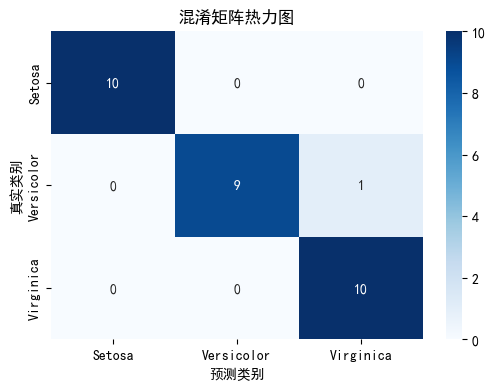

In [414]:
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Setosa', 'Versicolor', 'Virginica'], yticklabels=['Setosa', 'Versicolor', 'Virginica'])
plt.xlabel('预测类别')
plt.ylabel('真实类别')
plt.title('混淆矩阵热力图')
plt.show()

可以看到预测效果还不错！